In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception

In [ ]:
img_size = (224, 224)
BATCH_SIZE=32

In [ ]:
train_dir = "/content/drive/MyDrive/CovidDataset/Train"
val_dir= "/content/drive/MyDrive/CovidDataset/Test"
test_dir="/content/drive/MyDrive/CovidDataset/Val"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)


Found 6591 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 1423 images belonging to 2 classes.


In [ ]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)


In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//BATCH_SIZE,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_generator.n//BATCH_SIZE
)

Epoch 1/25
205/205 [==============================] - 1973s 9s/step - loss: 0.5050 - accuracy: 0.7695 - val_loss: 0.3783 - val_accuracy: 0.8423
Epoch 2/25
205/205 [==============================] - 115s 560ms/step - loss: 0.4040 - accuracy: 0.8238 - val_loss: 0.3447 - val_accuracy: 0.8530
Epoch 3/25
205/205 [==============================] - 119s 580ms/step - loss: 0.3717 - accuracy: 0.8411 - val_loss: 0.3532 - val_accuracy: 0.8452
Epoch 4/25
205/205 [==============================] - 115s 560ms/step - loss: 0.3518 - accuracy: 0.8530 - val_loss: 0.3132 - val_accuracy: 0.8764
Epoch 5/25
205/205 [==============================] - 116s 564ms/step - loss: 0.3466 - accuracy: 0.8521 - val_loss: 0.3230 - val_accuracy: 0.8828
Epoch 6/25
205/205 [==============================] - 115s 561ms/step - loss: 0.3373 - accuracy: 0.8556 - val_loss: 0.3063 - val_accuracy: 0.8743
Epoch 7/25
205/205 [==============================] - 115s 558ms/step - loss: 0.3351 - accuracy: 0.8587 - val_loss: 0.3017 - v

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 1413 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

45/45 [==============================] - 386s 9s/step - loss: 0.2457 - accuracy: 0.9045
Test accuracy: 0.9044585824012756


In [ ]:
import numpy as np
np.random.seed(123)

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

45/45 [==============================] - 8s 177ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.40      0.35      0.37       565
           1       0.60      0.65      0.62       848

    accuracy                           0.53      1413
   macro avg       0.50      0.50      0.50      1413
weighted avg       0.52      0.53      0.52      1413



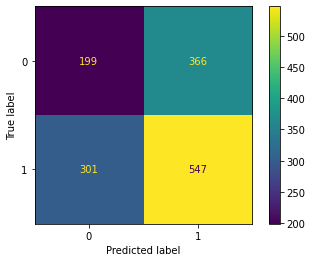

In [ ]:
print(ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes))

In [ ]:
import matplotlib.pyplot as plt

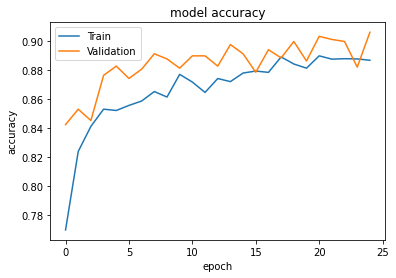

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

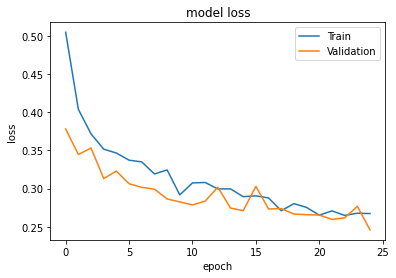

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 1s 1s/step


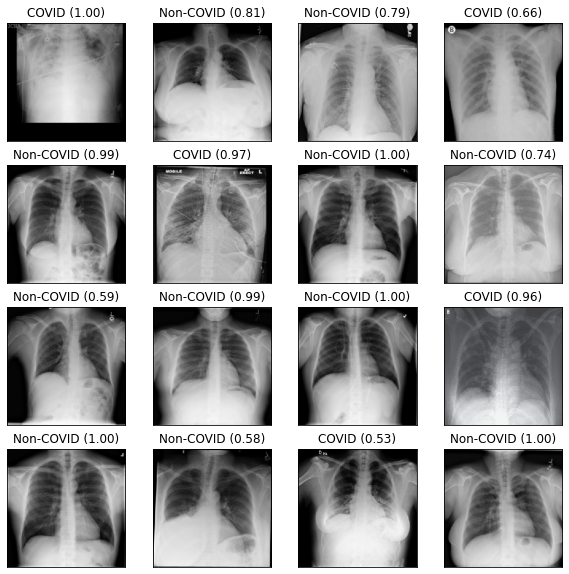

In [ ]:
test_images, test_labels = next(test_generator)
test_pred = model.predict(test_images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(test_images[i])

    # Set the title
    if test_pred[i][0] > 0.5:
        title = f'COVID ({test_pred[i][0]:.2f})'
    else:
        title = f'Non-COVID ({test_pred[i][1]:.2f})'
    ax.set_title(title)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])